In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import imblearn

import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
from torch.utils.data import Dataset, DataLoader

import collections

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder,LabelBinarizer ,MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
path = '/content/drive/Shareddrives/Spatial Data Project/'

land_use = pd.read_csv(path + "clean_df.csv", index_col= False)
#land_use = land_use.iloc[:,1:]
land_use.head()
mapping = pd.DataFrame([set(land_use['Commodity']),set(land_use['Commodity'].astype('category').cat.codes)]).T
mapping.to_csv(path+'class-mapping.csv')
land_use['Commodity'] = land_use['Commodity'].astype('category').cat.codes

It is clear from context that the columns Broad_type, Tertiary and Idx are not suitable for prediction since they are more response variables than anything.  Also classes are in str format, might not be suitable for NN? Solution maybe in a dictionary and restate the classes as numeric??

In [ ]:
X = land_use.drop(["Broad_type", "Idx", "Tertiary", "Commodity", "Closest_nature_reserve", "Nature_reserve_type"], axis = 1)
y = land_use["Commodity"]

X.columns

Index(['Submission_year', 'State', 'Area_ha', 'Collection_year',
       'Waterway_type', 'Distance_closest_waterway', 'Length_waterway',
       'Frost_days', 'Rain_days_1mm', 'Rain_days_2mm', 'Rain_days_3mm',
       'Rain_days_5mm', 'Rain_days_10mm', 'Rain_days_25mm', 'Sun_jan',
       'Sun_feb', 'Sun_mar', 'Sun_apr', 'Sun_may', 'Sun_jun', 'Sun_jul',
       'Sun_aug', 'Sun_sep', 'Sun_oct', 'Sun_nov', 'Sun_dec', 'Clay', 'Sand',
       'Silt', 'Organic_carbon', 'Annual_Mean_Temperature',
       'Mean_Diurnal_Range', 'Isothermality', 'Temperature_Seasonality',
       'Max_Temperature_of_Warmest_Month', 'Min_Temperature_of_Coldest_Month',
       'Temperature_Annual_Range', 'Mean_Temperature_of_Wettest_Quarter',
       'Mean_Temperature_of_Driest_Quarter',
       'Mean_Temperature_of_Warmest_Quarter',
       'Mean_Temperature_of_Coldest_Quarter', 'Annual_Precipitation',
       'Precipitation_of_Wettest_Month', 'Precipitation_of_Driest_Month',
       'Precipitation_Seasonality', 'Precipitati

In [ ]:
categorical_cols = ["State", "Waterway_type"]

state_categories = set(X['State'])
waterway_categories = set(X['State'])
reserve_categories = set(X['State'])
reserve_type_categories = set(X['State'])

numerical_cols = ['Area_ha', 'Distance_closest_waterway','Frost_days', 'Rain_days_1mm', 'Rain_days_2mm',
       'Rain_days_3mm', 'Rain_days_5mm', 'Rain_days_10mm', 'Rain_days_25mm',
       'Sun_jan', 'Sun_feb', 'Sun_mar', 'Sun_apr', 'Sun_may', 'Sun_jun',
       'Sun_jul', 'Sun_aug', 'Sun_sep', 'Sun_oct', 'Sun_nov', 'Sun_dec',
       'Annual_Mean_Temperature', 'Mean_Diurnal_Range', 'Isothermality',
       'Temperature_Seasonality', 'Max_Temperature_of_Warmest_Month',
       'Min_Temperature_of_Coldest_Month', 'Temperature_Annual_Range',
       'Mean_Temperature_of_Wettest_Quarter',
       'Mean_Temperature_of_Driest_Quarter',
       'Mean_Temperature_of_Warmest_Quarter',
       'Mean_Temperature_of_Coldest_Quarter', 'Annual_Precipitation',
       'Precipitation_of_Wettest_Month', 'Precipitation_of_Driest_Month',
       'Precipitation_Seasonality', 'Precipitation_of_Wettest_Quarter',
       'Precipitation_of_Driest_Quarter', 'Precipitation_of_Warmest_Quarter',
       'Precipitation_of_Coldest_Quarter', 'Elevation', 'Clay', 'Sand', 'Silt',
       'Organic_carbon', 'Is_irrigated']

In [ ]:
len(land_use["Commodity"].unique())

74

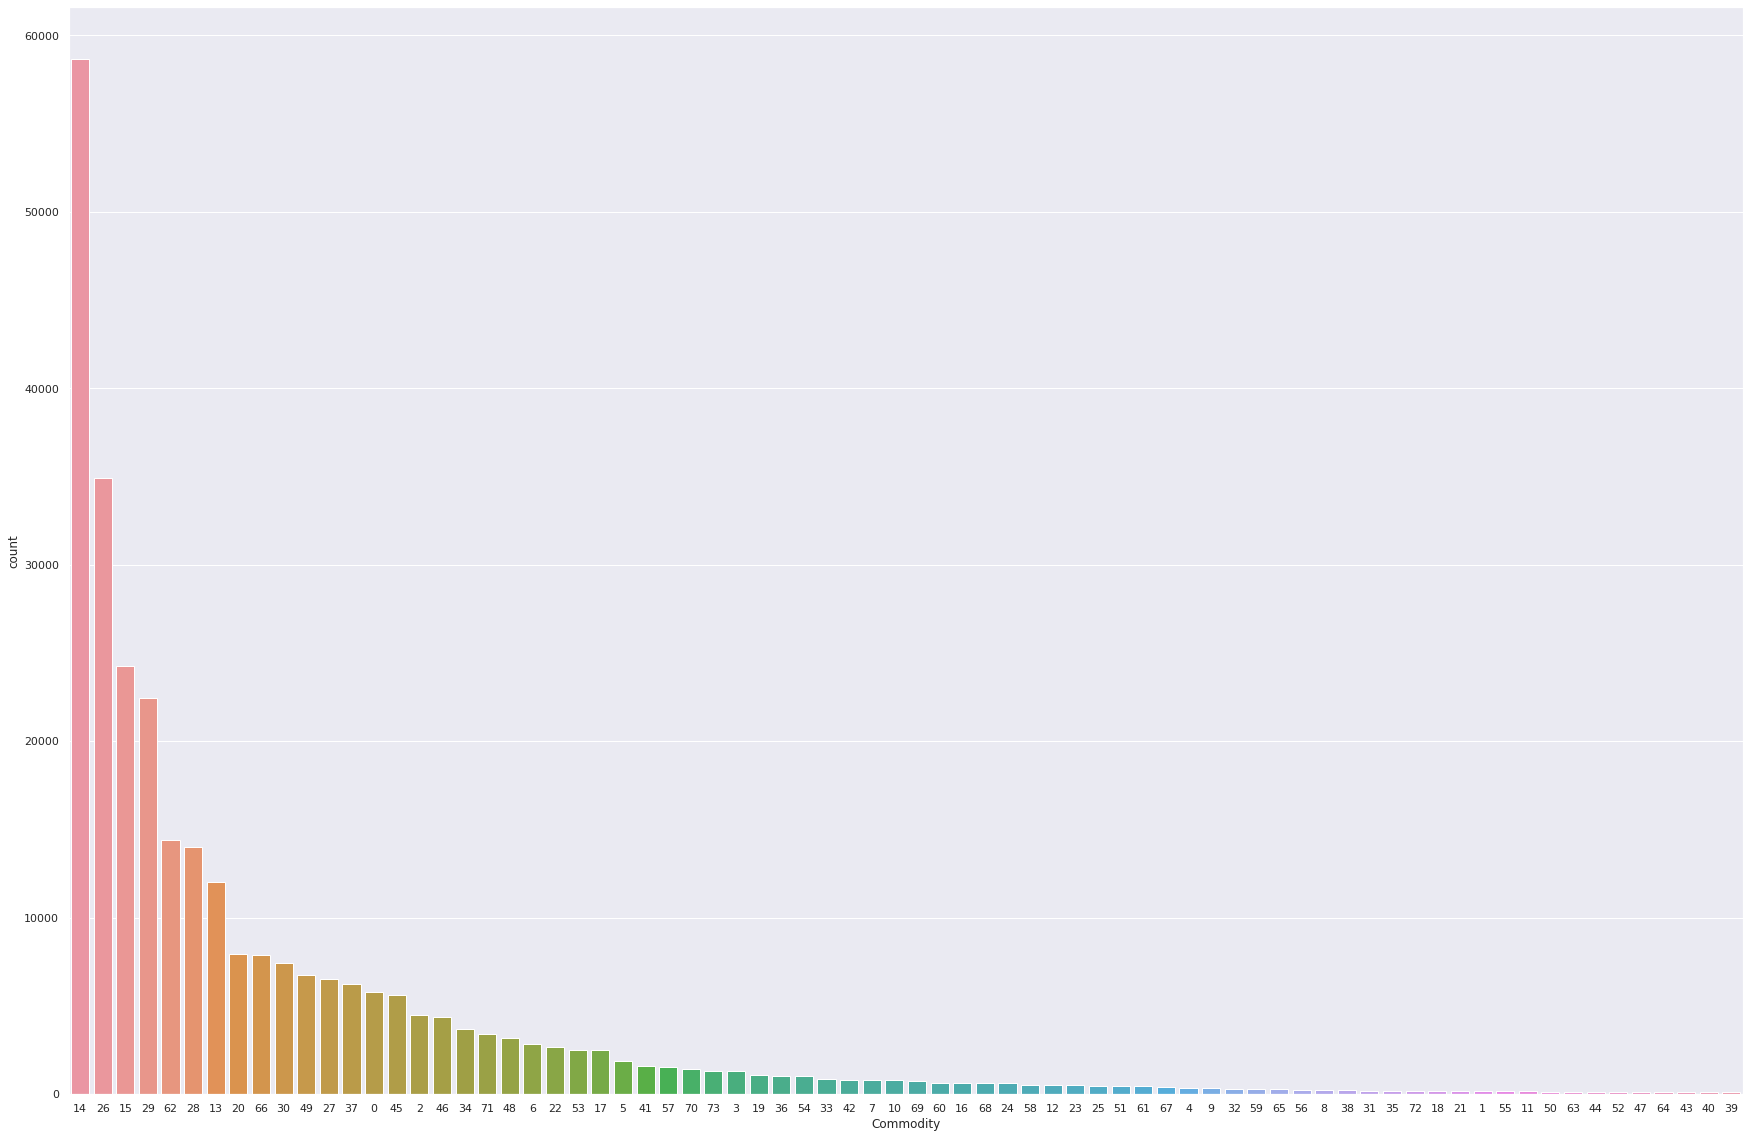

In [ ]:
sns.set(rc = {'figure.figsize':(30,20)})
sns.countplot(x = 'Commodity', data=land_use, order = land_use['Commodity'].value_counts().index)

In [ ]:
plt.savefig('class_imbalance.png', dpi =300)

<Figure size 2160x1440 with 0 Axes>

Very clear class imbalance here, not suitable for direct prediction.


We should split the data before so we don't carry information from before the split to the pipe line. I'll leave the code for the splitting in a way that deals with class imbalance from the beggining. The stratify argument ensures that each class is going to have the same amount of class sizes. 

In [ ]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [ ]:
from sklearn.preprocessing import LabelBinarizer

numeric_preprocessor = Pipeline(
    steps=[
        ("imputation_median", SimpleImputer(missing_values=np.nan, strategy="median")),
        ("scaler", MinMaxScaler())
    ]
)

categorical_preprocessor = Pipeline(
    steps=[
        ("binary_encoder", OneHotEncoder(sparse=False,handle_unknown ='ignore')),
        ("imputation_nn",KNNImputer(missing_values=np.nan, n_neighbors=5),
        )
        
    ]
)

preprocessor = ColumnTransformer(
    [
        ("categorical", categorical_preprocessor, categorical_cols),
        ("numerical", numeric_preprocessor, numerical_cols)
    ]
)

In [ ]:
X_new = X_test.sample(50)
X_train = preprocessor.fit_transform(X_train)
X_trainval = preprocessor.transform(X_trainval)
X_test = preprocessor.transform(X_test)
X_val = preprocessor.transform(X_val)

In [ ]:
oversample = imblearn.over_sampling.SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)
len(y_train)

3126130

Transforming the split to tensors

In [ ]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

train_dataset = ClassifierDataset(torch.from_numpy(np.array(X_train,dtype='float64')).float(),
torch.from_numpy(np.array(y_train,dtype='float64')).long())

val_dataset = ClassifierDataset(torch.from_numpy(np.array(X_val,dtype='float64')).float(),
torch.from_numpy(np.array(y_val,dtype='float64')).long())

test_dataset = ClassifierDataset(torch.from_numpy(np.array(X_test,dtype='float64')).float(),
torch.from_numpy(np.array(y_test,dtype='float64')).long())

Initialize parameters of our NN

In [ ]:
EPOCHS = 30 #These could all be different 
BATCH_SIZE = 1000 #Should probably be much bigger
LEARNING_RATE = 0.0007
NUM_FEATURES = len(X_val[0])
NUM_CLASSES = len(y.unique())

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle = True)

val_loader = DataLoader(dataset=val_dataset, batch_size=1)#Batch size should probably be different here

test_loader = DataLoader(dataset=test_dataset, batch_size=1)

Create the NN, some of these can be edited/removed but careful with the dimensions

In [ ]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(63, 1024) # These numbers should/could be different
        self.layer_2 = nn.Linear(1024, 1024)
        self.layer_3 = nn.Linear(1024, 512)
        self.layer_out = nn.Linear(512, num_class)
        self.softmax = nn.Softmax() 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(1024)
        self.batchnorm2 = nn.BatchNorm1d(1024)
        self.batchnorm3 = nn.BatchNorm1d(512)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        #x = self.softmax(x)
        
        return x

Check if you have a GPU that can run this quickly

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Softmax layer for the last step

In [ ]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

accuracy_stats = {
    'train': [],
    "val": [] }
    
loss_stats = {
    'train': [],
    "val": [] }

Training portion

In [ ]:
print("Begin training.")

for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.21500 | Val Loss: 1.46914 | Train Acc: 58.217| Val Acc: 48.996
Epoch 002: | Train Loss: 1.03193 | Val Loss: 1.40529 | Train Acc: 63.365| Val Acc: 51.167
Epoch 003: | Train Loss: 0.97790 | Val Loss: 1.36848 | Train Acc: 65.013| Val Acc: 53.005
Epoch 004: | Train Loss: 0.94664 | Val Loss: 1.39080 | Train Acc: 65.944| Val Acc: 51.523
Epoch 005: | Train Loss: 0.92507 | Val Loss: 1.36895 | Train Acc: 66.593| Val Acc: 52.045
Epoch 006: | Train Loss: 0.90788 | Val Loss: 1.35261 | Train Acc: 67.105| Val Acc: 52.559
Epoch 007: | Train Loss: 0.89426 | Val Loss: 1.33154 | Train Acc: 67.542| Val Acc: 53.159
Epoch 008: | Train Loss: 0.88325 | Val Loss: 1.34155 | Train Acc: 67.851| Val Acc: 52.911
Epoch 009: | Train Loss: 0.87395 | Val Loss: 1.29878 | Train Acc: 68.148| Val Acc: 54.140
Epoch 010: | Train Loss: 0.86628 | Val Loss: 1.27064 | Train Acc: 68.359| Val Acc: 54.534
Epoch 011: | Train Loss: 0.86004 | Val Loss: 1.28715 | Train Acc: 68.561| Val Acc: 54.136
Epoch 012:

Visualization of the training validation set

In [ ]:
# Create dataframes
#train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})#
#train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})# Plot the dataframes#
#fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))#
#sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')#
#sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

Evaluation of the test set

In [ ]:
y_pred_list = []
y_top3_list = []
y_top3probs_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred_probas = torch.softmax(y_test_pred, dim = 1)
        
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        top3probs, top3 = torch.topk(y_test_pred_probas,3,dim=1)
        
        y_top3probs_list.append(top3probs.cpu().numpy())
        y_top3_list.append(top3.cpu().numpy())
        y_pred_list.append(y_pred_tags.cpu().numpy())

y_top_3probs = [a.squeeze().tolist() for a in y_top3probs_list]
y_top_3 = [a.squeeze().tolist() for a in y_top3_list]
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

Checking how well we did

In [ ]:
right_preds=0

for predicted,y_true in zip(y_top_3,y_test):
  if y_true in predicted:
    right_preds+=1

acc = right_preds/len(y_test)
print("Percentage of 3-choice vectors including the true label",round(acc*100,2),"%")

Percentage of 3-choice vectors including the true label 84.46 %


In [ ]:
idx2class = np.array(set(land_use['Commodity']))

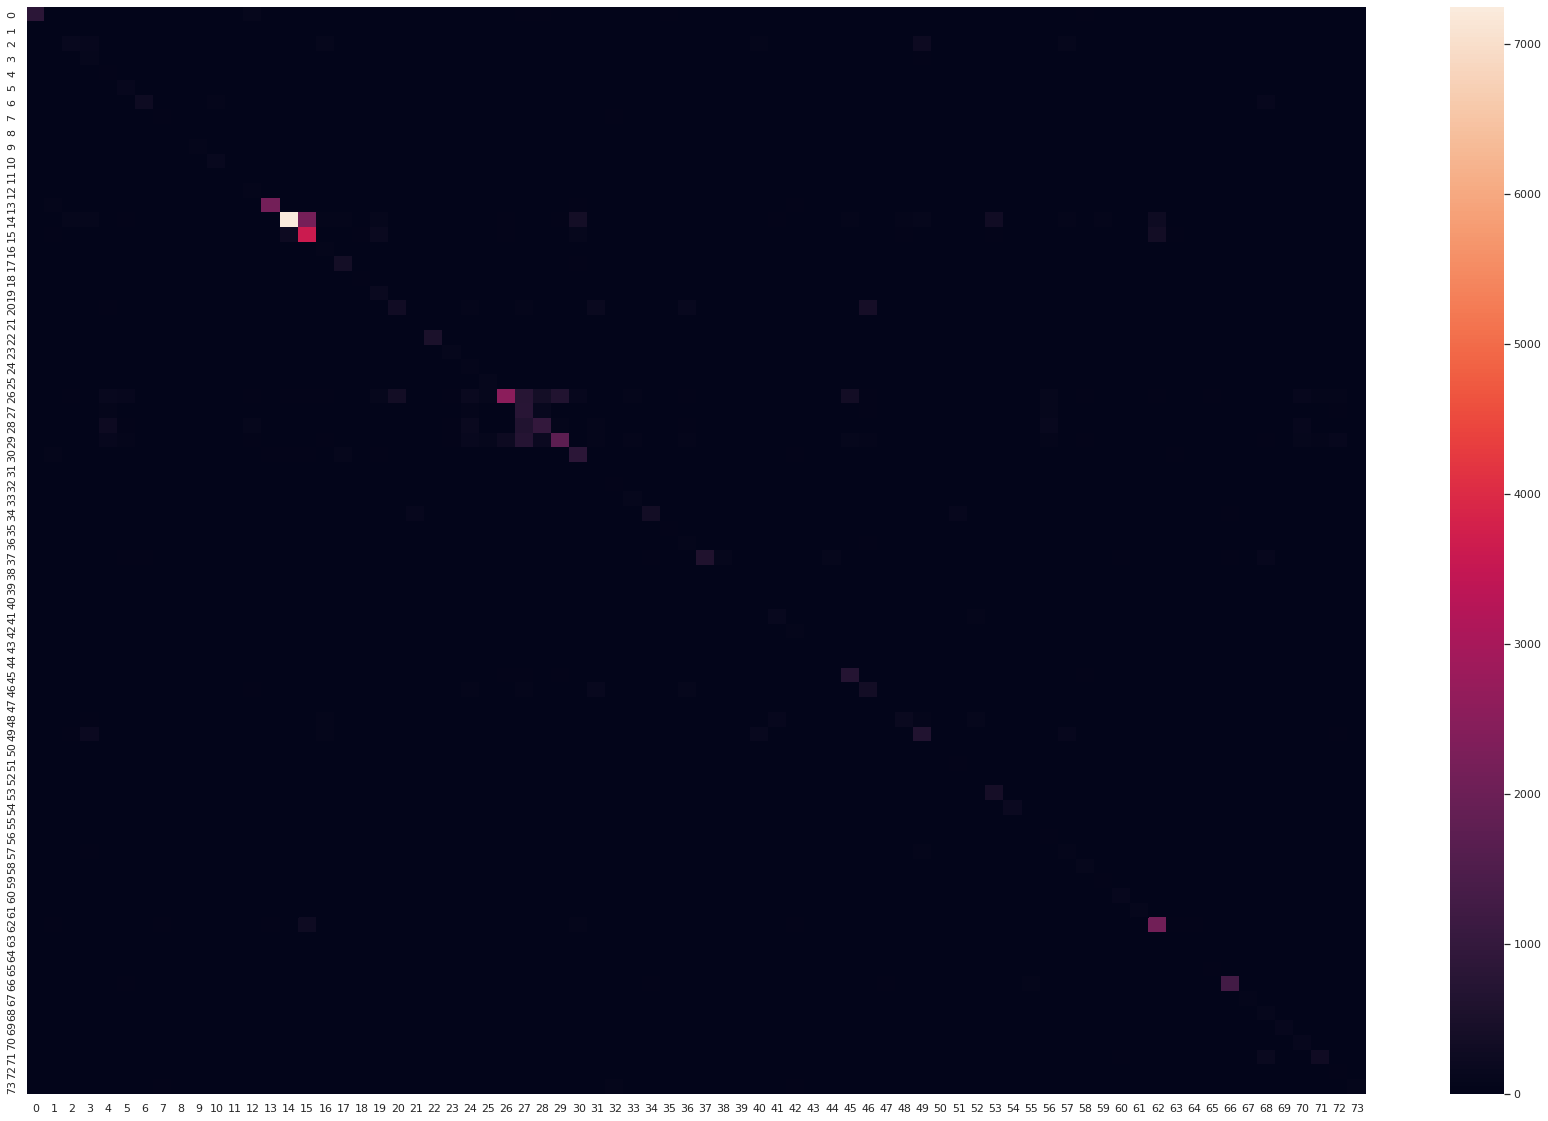

In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list))#.rename(columns=idx2class, index=idx2class)
sns.set(rc = {'figure.figsize':(30,20)})
sns.heatmap(confusion_matrix_df, annot=False)

In [ ]:
plt.savefig('balanced_confmat.png', dpi =300)

<Figure size 2160x1440 with 0 Axes>

In [ ]:
recall    = confusion_matrix_df.divide(confusion_matrix_df.sum(axis=1), axis=0)
precision = confusion_matrix_df.divide(confusion_matrix_df.sum(axis=0), axis=1)

In [ ]:
recall_diag_balanced    = np.diag(recall.applymap(lambda value: '{0:.2f} %'.format(value * 100)))
precision_diag_balanced = np.diag(precision.applymap(lambda value: '{0:.2f} %'.format(value * 100)))

In [ ]:
for i in range(21):
  print(y_top3_list[i],y_top3probs_list[i],np.array(y_test)[i])

[[70 12 28]] [[0.3538111  0.32738578 0.24246064]] 70
[[56  5 28]] [[0.4359504  0.24890137 0.16453451]] 28
[[19 53 62]] [[0.65390056 0.3441703  0.00069276]] 19
[[14 15 53]] [[0.9271196  0.07038051 0.00183391]] 14
[[25 29 26]] [[0.7063386  0.14544216 0.100064  ]] 29
[[45 26 20]] [[0.6214159  0.35658565 0.01274173]] 26
[[22 26 45]] [[9.9997067e-01 1.4723481e-05 7.7418699e-06]] 22
[[66 30 17]] [[9.9869579e-01 1.1986578e-03 9.9156001e-05]] 66
[[31 33 46]] [[0.20577389 0.1742276  0.15139289]] 29
[[23 28 27]] [[0.2284528  0.18500994 0.11725634]] 28
[[71  3 26]] [[0.62628907 0.27452195 0.06064011]] 71
[[15 14 62]] [[0.65521216 0.34393674 0.00068017]] 14
[[45 26 30]] [[0.5067387  0.43394563 0.05915374]] 26
[[66 37 34]] [[0.9830556  0.01023703 0.00553741]] 66
[[15 62 14]] [[0.64561504 0.19603612 0.15780479]] 15
[[45 29 71]] [[9.898168e-01 9.634511e-03 4.320817e-04]] 45
[[46 36 31]] [[0.3477781  0.1955849  0.18754645]] 20
[[ 4 46 31]] [[0.3605792  0.14750767 0.12648721]] 27
[[15 62 14]] [[0.80395

In [ ]:
torch.save(model.state_dict(),path+'model_weights_balanced.pt')

In [ ]:
model_unbalanced = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model_unbalanced.load_state_dict(torch.load(path+'model_weights_unbalanced.pt'))
model_unbalanced.to(device)

y_pred_list_unbalanced = []
y_top3_list_unbalanced = []
y_top3probs_list_unbalanced = []
with torch.no_grad():
    model_unbalanced.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model_unbalanced(X_batch)
        y_test_pred_probas = torch.softmax(y_test_pred, dim = 1)
        
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        top3probs, top3 = torch.topk(y_test_pred_probas,3,dim=1)
        
        y_top3probs_list_unbalanced.append(top3probs.cpu().numpy())
        y_top3_list_unbalanced.append(top3.cpu().numpy())
        y_pred_list_unbalanced.append(y_pred_tags.cpu().numpy())

y_top_3probs_unbalanced = [a.squeeze().tolist() for a in y_top3probs_list_unbalanced]
y_top_3_unbalanced = [a.squeeze().tolist() for a in y_top3_list_unbalanced]
y_pred_list_unbalanced = [a.squeeze().tolist() for a in y_pred_list_unbalanced]

In [ ]:
right_preds=0

for predicted,y_true in zip(y_top_3_unbalanced,y_test):
  if y_true in predicted:
    right_preds+=1

acc = right_preds/len(y_test)
print("Percentage of 3-choice vectors including the true label",round(acc*100,2),"%")

Percentage of 3-choice vectors including the true label 90.02 %


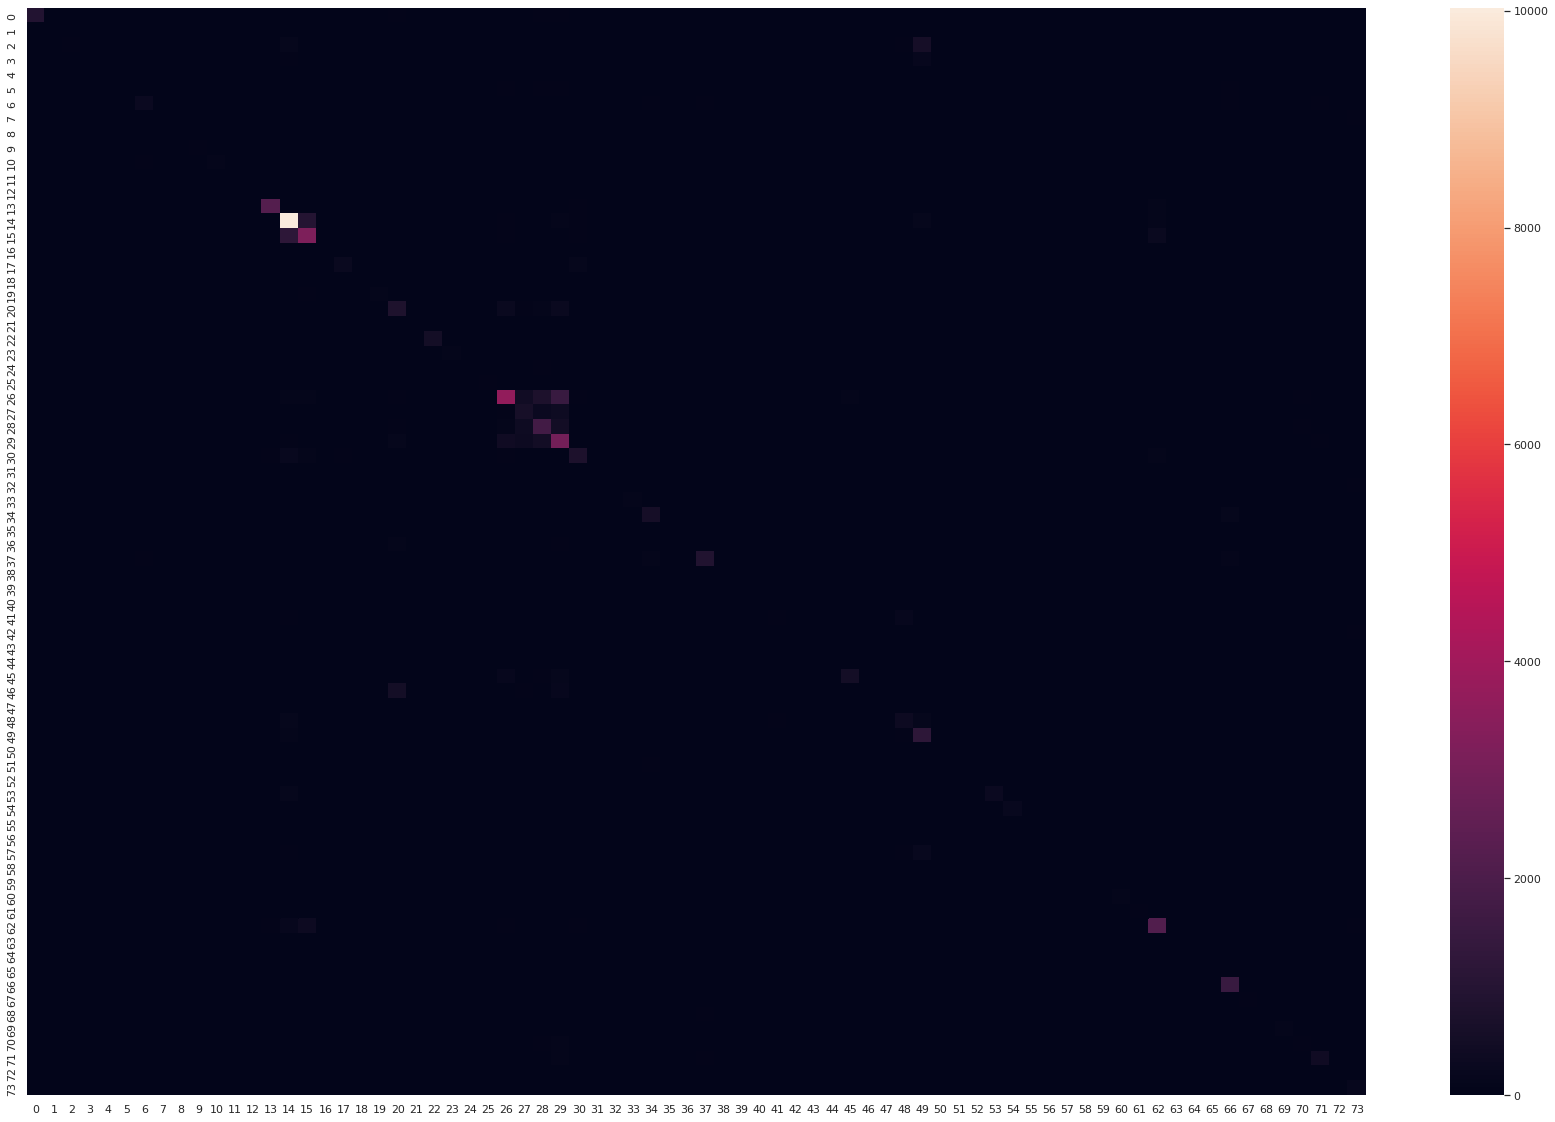

In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list_unbalanced))#.rename(columns=idx2class, index=idx2class)
sns.set(rc = {'figure.figsize':(30,20)})
sns.heatmap(confusion_matrix_df, annot=False)

In [ ]:
plt.savefig(path + 'unbalanced_confmat.png', dpi =300)

<Figure size 2160x1440 with 0 Axes>

In [ ]:
recall_unbalanced    = confusion_matrix_df.divide(confusion_matrix_df.sum(axis=1), axis=0)
precision_unbalanced = confusion_matrix_df.divide(confusion_matrix_df.sum(axis=0), axis=1)

recall_diag_unbalanced = np.diag(recall_unbalanced.applymap(lambda value: '{0:.2f} %'.format(value * 100)))
precision_diag_unbalanced = np.diag(precision_unbalanced.applymap(lambda value: '{0:.2f} %'.format(value * 100)))

In [ ]:
pd.set_option('display.max_rows', None)
prec_rec = pd.DataFrame([precision_diag_balanced, precision_diag_unbalanced, recall_diag_balanced, recall_diag_unbalanced]).transpose()
prec_rec.columns = ['precision_bal', 'precision_unbal', 'recall_bal', 'recall_unbal']
prec_rec.to_csv(path + 'prec_rec.csv')
prec_rec

,precision_bal,precision_unbal,recall_bal,recall_unbal
0,92.04 %,92.76 %,70.53 %,79.30 %
1,8.09 %,100.00 %,61.11 %,5.56 %
2,36.43 %,42.61 %,16.56 %,8.33 %
3,14.35 %,nan %,38.46 %,0.00 %
4,5.87 %,nan %,62.50 %,0.00 %
5,22.03 %,39.47 %,34.13 %,8.00 %
6,66.59 %,57.49 %,47.64 %,54.28 %
7,23.85 %,24.31 %,33.12 %,22.29 %
8,8.99 %,nan %,17.39 %,0.00 %
9,90.91 %,86.67 %,98.59 %,91.55 %


In [ ]:
#new_data = pd.read_csv(path + "test_df.csv", index_col= False)
#new_data['Is_irrigated'] = np.zeros(len(new_data['Is_irrigated']))
#new_data['Collection_year'] = land_use['Collection_year'].head(15)
#new_data['Submission_year'] = land_use['Submission_year'].head(15)
#new_data['Area_ha']= land_use['Area_ha'].head(15)
#new_data = new_data.loc[:,X.columns]
#new_data['Is_irrigated'] = np.ones(len(new_data['Is_irrigated']))

In [ ]:
X_new_0 = X_new.copy()
X_new_1 = X_new.copy()

X_new_0['Is_irrigated'] = np.zeros(len(X_new_0['Is_irrigated']))
X_new_1['Is_irrigated'] = np.ones(len(X_new_1['Is_irrigated']))

x_new_0 = preprocessor.transform(X_new_0)
x_new_1 = preprocessor.transform(X_new_1)
y_new = land_use['Commodity'].head(50)

new_dataset_0 = ClassifierDataset(torch.from_numpy(np.array(x_new_0,dtype='float64')).float(),
torch.from_numpy(np.array(y_new,dtype='float64')).long())
new_dataset_1 = ClassifierDataset(torch.from_numpy(np.array(x_new_1,dtype='float64')).float(),
torch.from_numpy(np.array(y_new,dtype='float64')).long())

x_new_loader_0 = DataLoader(dataset=new_dataset_0, batch_size=1)
x_new_loader_1 = DataLoader(dataset=new_dataset_1, batch_size=1)

In [ ]:
#Import unbalanced model from Drive
model_unbalanced = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model_unbalanced.load_state_dict(torch.load(path+'model_weights_unbalanced.pt'))
model_unbalanced.to(device)

y_new_list = []
y_top3_list_new = []
y_top3probs_list_new = []
#Predict with and without irrigation for balanced model (pre-trained here)
with torch.no_grad():
    model.eval()
    for X_batch,_ in x_new_loader_0:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred_probas = torch.softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        top3probs, top3 = torch.topk(y_test_pred_probas,3,dim=1)
        
        y_top3probs_list_new.append(top3probs.cpu().numpy())
        y_top3_list_new.append(top3.cpu().numpy())
        y_new_list.append(y_pred_tags.cpu().numpy())

y_top_3probs_0_balanced = [a.squeeze().tolist() for a in y_top3probs_list_new]
y_top_3_0_balanced = [a.squeeze().tolist() for a in y_top3_list_new]
y_new_list_pred_0_balanced = [a.squeeze().tolist() for a in y_new_list]

y_new_list = []
y_top3_list_new = []
y_top3probs_list_new = []

with torch.no_grad():
    model.eval()
    for X_batch,_ in x_new_loader_1:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred_probas = torch.softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        top3probs, top3 = torch.topk(y_test_pred_probas,3,dim=1)
        
        y_top3probs_list_new.append(top3probs.cpu().numpy())
        y_top3_list_new.append(top3.cpu().numpy())
        y_new_list.append(y_pred_tags.cpu().numpy())

y_top_3probs_1_balanced = [a.squeeze().tolist() for a in y_top3probs_list_new]
y_top_3_1_balanced = [a.squeeze().tolist() for a in y_top3_list_new]
y_new_list_pred_1_balanced = [a.squeeze().tolist() for a in y_new_list]

#Predict with and without irrigation for unbalanced model (Loaded from Drive)
y_new_list = []
y_top3_list_new = []
y_top3probs_list_new = []

with torch.no_grad():
    model_unbalanced.eval()
    for X_batch,_ in x_new_loader_0:
        X_batch = X_batch.to(device)
        y_test_pred = model_unbalanced(X_batch)
        y_test_pred_probas = torch.softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        top3probs, top3 = torch.topk(y_test_pred_probas,3,dim=1)
        
        y_top3probs_list_new.append(top3probs.cpu().numpy())
        y_top3_list_new.append(top3.cpu().numpy())
        y_new_list.append(y_pred_tags.cpu().numpy())

y_top_3probs_0_unbalanced = [a.squeeze().tolist() for a in y_top3probs_list_new]
y_top_3_0_unbalanced = [a.squeeze().tolist() for a in y_top3_list_new]
y_new_list_pred_0_unbalanced= [a.squeeze().tolist() for a in y_new_list]

y_new_list = []
y_top3_list_new = []
y_top3probs_list_new = []

with torch.no_grad():
    model_unbalanced.eval()
    for X_batch,_ in x_new_loader_1:
        X_batch = X_batch.to(device)
        y_test_pred = model_unbalanced(X_batch)
        y_test_pred_probas = torch.softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        top3probs, top3 = torch.topk(y_test_pred_probas,3,dim=1)
        
        y_top3probs_list_new.append(top3probs.cpu().numpy())
        y_top3_list_new.append(top3.cpu().numpy())
        y_new_list.append(y_pred_tags.cpu().numpy())

y_top_3probs_1_unbalanced = [a.squeeze().tolist() for a in y_top3probs_list_new]
y_top_3_1_unbalanced = [a.squeeze().tolist() for a in y_top3_list_new]
y_new_list_pred_1_unbalanced= [a.squeeze().tolist() for a in y_new_list]

In [ ]:
#Non-Irrigated-Balanced
X_new['y_top_3probs_0_balanced'] = y_top_3probs_0_balanced
X_new['y_top_3_0_balanced'] = y_top_3_0_balanced
X_new['y_new_list_0_balanced'] = y_new_list_pred_0_balanced
#Irrigated-Balanced
X_new['y_top_3probs_1_balanced'] = y_top_3probs_1_balanced
X_new['y_top_3_1_balanced'] = y_top_3_1_balanced
X_new['y_new_list_1_balanced'] = y_new_list_pred_1_balanced
#Non-Irrigated-UnBalanced
X_new['y_top_3probs_0_unbalanced'] = y_top_3probs_0_unbalanced
X_new['y_top_3_0_unbalanced'] = y_top_3_0_unbalanced
X_new['y_new_list_0_unbalanced'] = y_new_list_pred_0_unbalanced
#Irrigated-UnBalanced
X_new['y_top_3probs_1_unbalanced'] = y_top_3probs_1_unbalanced
X_new['y_top_3_1_unbalanced'] = y_top_3_1_unbalanced
X_new['y_new_list_1_unbalanced'] = y_new_list_pred_1_unbalanced

In [ ]:
X_new.to_csv(path+'results_all.csv')

In [ ]:
pd.set_option('display.max_columns', None)
X_new

,Submission_year,State,Area_ha,Collection_year,Waterway_type,Distance_closest_waterway,Length_waterway,Frost_days,Rain_days_1mm,Rain_days_2mm,Rain_days_3mm,Rain_days_5mm,Rain_days_10mm,Rain_days_25mm,Sun_jan,Sun_feb,Sun_mar,Sun_apr,Sun_may,Sun_jun,Sun_jul,Sun_aug,Sun_sep,Sun_oct,Sun_nov,Sun_dec,Clay,Sand,Silt,Organic_carbon,Annual_Mean_Temperature,Mean_Diurnal_Range,Isothermality,Temperature_Seasonality,Max_Temperature_of_Warmest_Month,Min_Temperature_of_Coldest_Month,Temperature_Annual_Range,Mean_Temperature_of_Wettest_Quarter,Mean_Temperature_of_Driest_Quarter,Mean_Temperature_of_Warmest_Quarter,Mean_Temperature_of_Coldest_Quarter,Annual_Precipitation,Precipitation_of_Wettest_Month,Precipitation_of_Driest_Month,Precipitation_Seasonality,Precipitation_of_Wettest_Quarter,Precipitation_of_Driest_Quarter,Precipitation_of_Warmest_Quarter,Precipitation_of_Coldest_Quarter,Elevation,Is_irrigated,y_top_3probs_0_balanced,y_top_3_0_balanced,y_new_list_0_balanced,y_top_3probs_1_balanced,y_top_3_1_balanced,y_new_list_1_balanced,y_top_3probs_0_unbalanced,y_top_3_0_unbalanced,y_new_list_0_unbalanced,y_top_3probs_1_unbalanced,y_top_3_1_unbalanced,y_new_list_1_unbalanced
217045,2017,Vic,0.846281,2016,river,7.903597,0.000000,18.400000,53,41,32,21,10,2,10,10,8,7,5,4,4,5,7,8,9,10,NaN,NaN,NaN,157.0,161.0,132.0,48.0,4999.0,312.0,39.0,273.0,129.0,226.0,226.0,98.0,373.0,41.0,21.0,20.0,115.0,71.0,71.0,105.0,73.0,1,"[0.9764707088470459, 0.02313392050564289, 0.00...","[19, 26, 53]",19,"[0.3910026252269745, 0.3528616726398468, 0.128...","[70, 35, 24]",70,"[0.9028968811035156, 0.0718865916132927, 0.007...","[26, 19, 30]",26,"[0.22792848944664001, 0.18193893134593964, 0.1...","[70, 28, 26]",70
258143,2015,SA,61.071200,2014,river,0.236423,0.000000,13.300000,41,28,21,13,5,1,10,9,8,7,5,4,5,6,7,8,9,9,180.0,686.0,134.0,291.0,168.0,140.0,51.0,4711.0,319.0,47.0,272.0,115.0,225.0,228.0,108.0,264.0,28.0,13.0,20.0,78.0,50.0,53.0,74.0,35.0,1,"[0.8829922080039978, 0.06292825192213058, 0.04...","[30, 53, 14]",30,"[0.6389151215553284, 0.2120511680841446, 0.148...","[20, 45, 26]",20,"[0.697548508644104, 0.19797846674919128, 0.057...","[30, 53, 17]",30,"[0.515748143196106, 0.40718263387680054, 0.057...","[26, 20, 45]",26
250118,2016,Vic,0.993227,2016,river,1.628007,0.000000,21.466670,47,37,29,20,9,2,10,10,8,7,5,4,5,6,7,8,9,10,188.0,737.0,75.0,203.0,166.0,137.0,48.0,5162.0,321.0,37.0,284.0,134.0,232.0,232.0,100.0,357.0,37.0,23.0,15.0,105.0,74.0,74.0,93.0,63.0,1,"[0.8706666231155396, 0.08142182230949402, 0.04...","[53, 30, 26]",53,"[0.8056073188781738, 0.09246314316987991, 0.07...","[36, 20, 46]",36,"[0.7135484218597412, 0.18941491842269897, 0.05...","[26, 53, 14]",26,"[0.2898107171058655, 0.24655979871749878, 0.16...","[20, 46, 29]",20
242323,2017,Vic,0.505785,2016,river,54.829170,0.000000,35.100000,70,55,44,32,15,3,9,9,8,6,4,3,3,5,6,7,8,9,174.0,586.0,240.0,455.0,152.0,123.0,46.0,5097.0,301.0,34.0,267.0,97.0,216.0,218.0,88.0,557.0,62.0,28.0,20.0,171.0,107.0,107.0,167.0,118.0,1,"[0.5275932550430298, 0.2604023218154907, 0.106...","[2, 30, 49]",2,"[0.2642558217048645, 0.24189020693302155, 0.18...","[49, 3, 57]",49,"[0.4636528789997101, 0.3413200080394745, 0.093...","[14, 30, 2]",14,"[0.6342605352401733, 0.18150858581066132, 0.07...","[49, 2, 57]",49
267562,2015,Qld,3.026160,2015,river,14.391520,0.000000,0.000000,130,114,102,81,56,28,6,5,5,6,5,6,6,7,8,8,8,7,371.0,367.0,262.0,578.0,240.0,87.0,55.0,2477.0,310.0,154.0,156.0,265.0,211.0,267.0,204.0,2960.0,572.0,59.0,79.0,1654.0,191.0,1329.0,235.0,92.0,0,"[0.9911138415336609, 0.0057579344138503075, 0....","[66, 17, 30]",66,"[0.999360978603363, 0.0006383892032317817, 2.8...","[69, 6, 5]",69,"[0.9660184979438782, 0.03285927325487137, 0.00...","[66, 30, 17]",66,"[0.8118258714675903, 0.18449100852012634, 0.00...","[69, 6, 66]",69
220695,2017,Vic,0.441349,2016,river,3.872076,0.000000,12.866670,42,31,25,16,7,2,10,10,9,7,5,5,5,6,7,8,9,10,NaN,NaN,NaN,NaN,171.0,137.0,48.0,5145.0,326.0,41.0,285.0,140.0,208.0,237.0,105.0,297.0,31.0,20.0,15.